In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils.init import *

notebook ready
token ready
local simulator ready
aer_simulator


In [3]:
circuit = QuantumCircuit(2)  # You can also create a circuit by specifying the number of bits without using a register
circuit.h(0)  # Qubits can be addressed by their index within the circuit
circuit.ry(np.pi / 2., 0)  #　θ = π/2
circuit.x(0)
# Measurement is always needed to get an output
circuit.measure_all()

print(f'This circuit has {circuit.num_qubits} qubits and {circuit.size()} operations')

This circuit has 2 qubits and 5 operations


In [4]:
theta1 = 2. * np.arctan(np.sqrt(7. / 3.))
theta2 = 2. * np.arctan(np.sqrt(2.))
theta3 = 2. * np.arctan(np.sqrt(4. / 3))

circuit = QuantumCircuit(2)
circuit.ry(theta1, 1)
circuit.ry(theta2, 0)
circuit.cry(theta3 - theta2, 1, 0)  # C[Ry]　1が制御で0が標的
circuit.cz(0, 1)  # C[Z] 0が制御で1が標的（実はC[Z]ではどちらが制御でも結果は同じ）
circuit.measure_all()

print(f'This circuit has {circuit.num_qubits} qubits and {circuit.size()} operations')

This circuit has 2 qubits and 6 operations


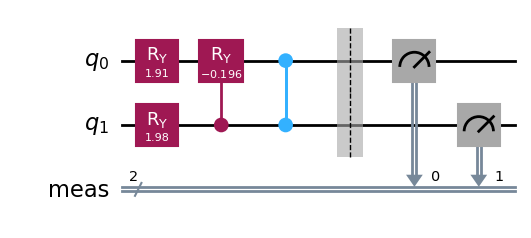

In [5]:
circuit.draw('mpl')

In [6]:
circuit.draw()

┌────────────┐┌──────────────┐    ░ ┌─┐   
   q_0: ┤ Ry(1.9106) ├┤ Ry(-0.19649) ├─■──░─┤M├───
        ├────────────┤└──────┬───────┘ │  ░ └╥┘┌─┐
   q_1: ┤ Ry(1.9823) ├───────■─────────■──░──╫─┤M├
        └────────────┘                    ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1

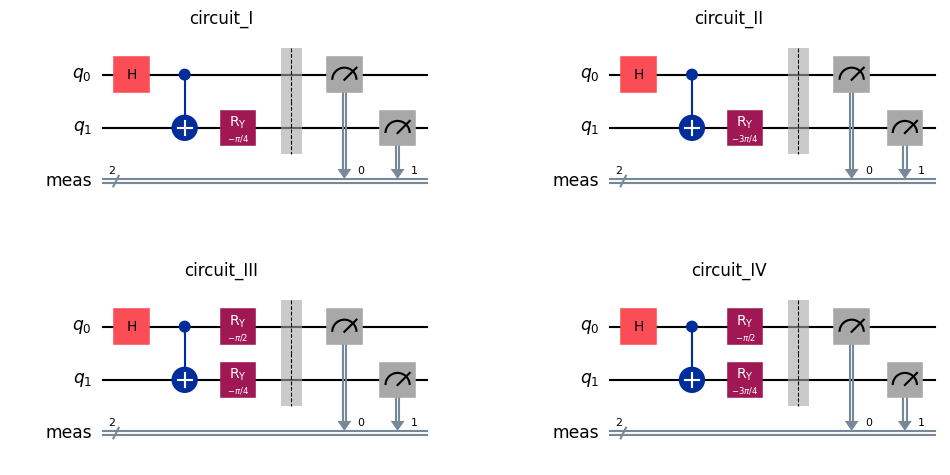

In [7]:
circuits = []

# Circuit I - H, CX[0, 1], Ry(-π/4)[1]
circuit = QuantumCircuit(2, name='circuit_I')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit II - H, CX[0, 1], Ry(-3π/4)[1]
circuit = QuantumCircuit(2, name='circuit_II')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit III - H, CX[0, 1], Ry(-π/4)[1], Ry(-π/2)[0]
circuit = QuantumCircuit(2, name='circuit_III')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit IV - H, CX[0, 1], Ry(-3π/4)[1], Ry(-π/2)[0]
circuit = QuantumCircuit(2, name='circuit_IV')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# draw() can accept a matplotlib Axes object as an argument, to which the circuit will be drawn
# This is useful when visualizing multiple circuits from a single Jupyter cell
fig, axs = plt.subplots(2, 2, figsize=[12., 6.])
for circuit, ax in zip(circuits, axs.reshape(-1)):
    circuit.draw('mpl', ax=ax)
    ax.set_title(circuit.name)

In [8]:
# Find the backend that is operational and has the shortest job queue
backend = service.least_busy(filters=operational_backend())
sampler = IBMSampler(backend)

print(f'Jobs will run on {backend.name}')

Jobs will run on ibm_kyiv


In [9]:
# max_shots = the maximum number of allowed shots for this backend with the access parameters
shots = min(backend.max_shots, 2000)
print(f'Running four circuits, {shots} shots each')

circuits = transpile(circuits, backend=backend)
# Execute each circuit for `shots` times
# job = sampler.run(circuits, shots=shots)

/tmp/ipykernel_257974/1478407098.py:2: DeprecationWarning: max_shots is deprecated as of qiskit-ibm-runtime 0.37.0 and will be removed no sooner than 3 months after the release date. Please see our documentation on job limits https://docs.quantum.ibm.com/guides/job-limits#job-limits.
  shots = min(backend.max_shots, 2000)


Running four circuits, 2000 shots each


In [10]:
job = service.job('d00pc4rqnmvg008wg8ag')
result = job.result()

# List to collect the histogram data from the four circuits
counts_list = []

# Extracting the bit sequence counts from the result object
for idx in range(4):
    # get_counts(i) returns the histogram data for circuit i
    counts = result[idx].data.meas.get_counts()
    # Append to list
    counts_list.append(counts)

print(counts_list)

[{'00': 851, '11': 859, '01': 162, '10': 128}, {'10': 832, '00': 167, '01': 849, '11': 152}, {'00': 896, '11': 853, '01': 115, '10': 136}, {'00': 852, '11': 844, '10': 166, '01': 138}]


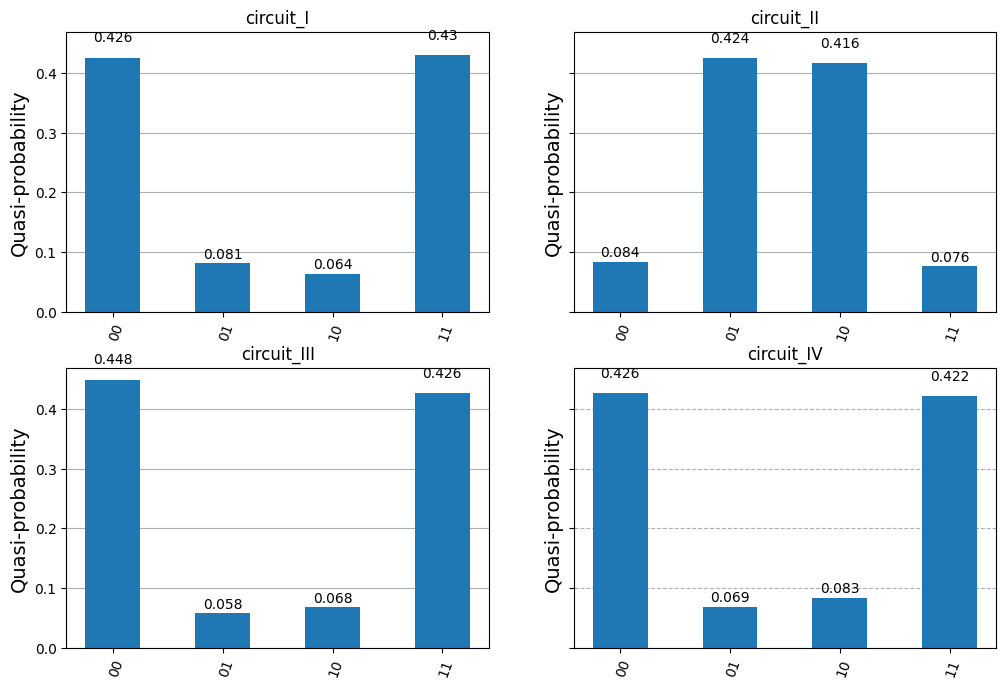

In [11]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=[12., 8.])
for counts, circuit, ax in zip(counts_list, circuits, axs.reshape(-1)):
    plot_distribution(counts, ax=ax)
    ax.set_title(circuit.name)
    ax.yaxis.grid(True)

In [12]:
# C^I, C^II, C^III, C^IVを一つのアレイにする
#（今の場合ただのリストにしてもいいが、純粋な数字の羅列にはnumpy arrayを使うといいことが多い）
c_arr = np.zeros(4, dtype=float)

# enumerate(L)でリストのインデックスと対応する要素に関するループを回せる
for ic, counts in enumerate(counts_list):
    # counts['00'] でなく counts.get('00', 0) - 上のテキストを参照
    c_arr[ic] = counts.get('00', 0) + counts.get('11', 0) - counts.get('01', 0) - counts.get('10', 0)

# 4つの要素を同時にshotsで規格化（リストではこういうことはできない）
c_arr /= shots

s_val = c_arr[0] - c_arr[1] + c_arr[2] + c_arr[3]

print('C:', c_arr)
print('S =', s_val)
if s_val > 2.:
    print('Yes, we are using a quantum computer!')
else:
    print('Armonk, we have a problem.')

C: [ 0.71  -0.681  0.749  0.696]
S = 2.8360000000000003
Yes, we are using a quantum computer!
